# COMP0026 - Image Processing

# 2021/22 Coursework 1 - Face Morphing 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import dlib
from scipy.spatial import Delaunay

# 1.) Loading Images

OpenCV will read in image pixel as BGR value, so we need to convert it back to RGB for display using pyplot.

In [2]:
# input the image path and return a numpy array of the image
def loadImage(path):
    img = np.array(cv2.imread(path))
    # opencv read in image as BGR, so we need to convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [3]:
# plot 2 images
def plot2Images(img1, img2, title1, title2):
    fig = plt.figure(figsize=(15, 15))
    ax1 = plt.subplot(1, 2, 1)
    ax1.title.set_text(title1)
    plt.imshow(img1)
    ax2 = plt.subplot(1, 2, 2)
    ax2.title.set_text(title2)
    plt.imshow(img2)

# plot 3 images
def plot3Images(img1, img2, img3, title1, title2, title3):
    fig = plt.figure(figsize=(15, 15))
    ax1 = plt.subplot(1, 3, 1)
    ax1.title.set_text(title1)
    plt.imshow(img1)
    ax2 = plt.subplot(1, 3, 2)
    ax2.title.set_text(title2)
    plt.imshow(img2)
    ax3 = plt.subplot(1, 3, 3)
    ax3.title.set_text(title3)
    plt.imshow(img3)

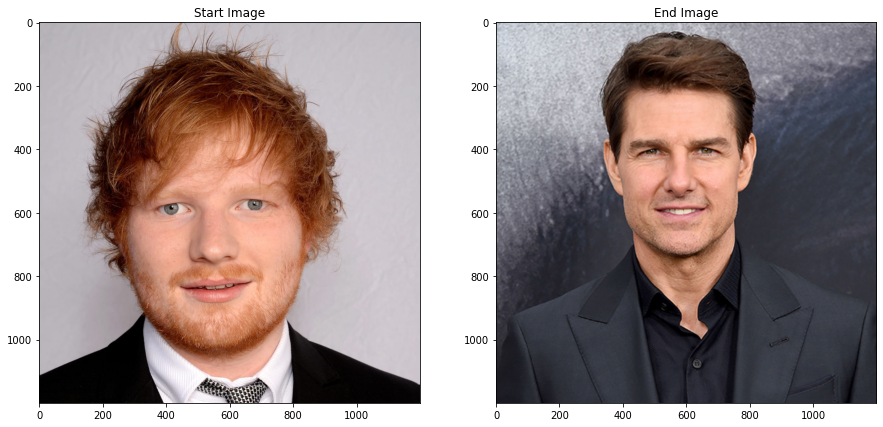

In [4]:
# loading images
startImg = loadImage("./images/ed-sheeran.jpg")
endImg = loadImage("./images/tom-cruise.jpg")

# plot images
plot2Images(startImg, endImg, "Start Image", "End Image")

In [5]:
print("Start image shape: ",startImg.shape)
print("End image shape: ",endImg.shape)

Start image shape:  (1200, 1200, 3)
End image shape:  (1200, 1200, 3)


# 2.) Face Landmark Detection Using dlib

The following function will return a list of x and y coordinates of the 68 points detected by the dlib face landmark detector, plus 16 points of the corner and the edges of the image, and 16 points of the corner and edges of the face detector. Each point from the list is in an order that corresponding to a specific feature of the image(e.g. point 18-22: left eye, point 23-27: right eye, point 32-36: nose, etc.) 

In [6]:
# add 16 points around the bounding rectangle of the face detector
def addPointsOnFaceDetectorCornerAndEdges(landmarksList, img, faceRect):
    imgW, imgH = img.shape[0], img.shape[1]
    xOffset = 100
    yOffset = 100
    x = y = w = h = 0
    
    if (faceRect.left() - xOffset) >= 0:
        x = faceRect.left() - xOffset
    else:
        x = 0
        
    if (faceRect.right() + xOffset) <= imgW - 1:
        w = (faceRect.right() + xOffset) - x
    else:
        w = (imgW - 1) - x
        
    if (faceRect.top() - yOffset) >= 0:
        y = faceRect.top() - yOffset
    else:
        y = 0
    
    if (faceRect.bottom() + yOffset) <= imgH - 1:
        h = (faceRect.bottom() + yOffset) - y
    else:
        h = (imgH - 1) - y
    
    topLeft = [x,y]
    landmarksList.append(topLeft)
    
    left1 = [x, int(y + h/4)]
    landmarksList.append(left1)
        
    left2 = [x, int(y + h/2)]
    landmarksList.append(left2)
    
    left3 = [x, int(y + h*3/4)]
    landmarksList.append(left3)
        
    bottomLeft = [x, (y + h)]
    landmarksList.append(bottomLeft)
        
    bottom1 = [int(x + w/4), (y + h)]
    landmarksList.append(bottom1)
    
    bottom2 = [int(x + w/2), (y + h)]
    landmarksList.append(bottom2)
    
    bottom3 = [int(x + w*3/4), (y + h)]
    landmarksList.append(bottom3)
        
    bottomRight = [(x + w), (y + h)]
    landmarksList.append(bottomRight)
        
    right1 = [(x + w), int(y + h/4)]
    landmarksList.append(right1)
    
    right2 = [(x + w), int(y + h/2)]
    landmarksList.append(right2)
    
    right3 = [(x + w), int(y + h*3/4)]
    landmarksList.append(right3)
        
    topRight = [(x + w), y]
    landmarksList.append(topRight)
        
    top1 = [int(x + w/4), y]
    landmarksList.append(top1)
    
    top2 = [int(x + w/2), y]
    landmarksList.append(top2)
    
    top3 = [int(x + w*3/4), y]
    landmarksList.append(top3)
    

In [7]:
# add 16 points around the image
def addPointsOnImgCornerAndEdges(landmarksList, img):
    w = img.shape[0]
    h = img.shape[1]
    
    topLeft = [0,0]
    landmarksList.append(topLeft)
        
    left1 = [0, int((h - 1) / 4)]
    landmarksList.append(left1)
    
    left2 = [0, int((h - 1) / 2)]
    landmarksList.append(left2)
    
    left3 = [0, int((h - 1) * 3/4)]
    landmarksList.append(left3)
        
    bottomLeft = [0, h - 1]
    landmarksList.append(bottomLeft)
        
    bottom1 = [int((w - 1) / 4), h - 1]
    landmarksList.append(bottom1)
    
    bottom2 = [int((w - 1) / 2), h - 1]
    landmarksList.append(bottom2)
    
    bottom3 = [int((w - 1) * 3/4), h - 1]
    landmarksList.append(bottom3)
        
    bottomRight = [w - 1, h - 1]
    landmarksList.append(bottomRight)
        
    right1 = [w - 1, int((h - 1) / 4)]
    landmarksList.append(right1)
    
    right2 = [w - 1, int((h - 1) / 2)]
    landmarksList.append(right2)
    
    right3 = [w - 1, int((h - 1) * 3/4)]
    landmarksList.append(right3)
        
    topRight = [w - 1, 0]
    landmarksList.append(topRight)
        
    top1 = [int((w - 1) / 4), 0]
    landmarksList.append(top1)
    
    top2 = [int((w - 1) / 2), 0]
    landmarksList.append(top2)
    
    top3 = [int((w - 1) * 3/4), 0]
    landmarksList.append(top3)
    

In [8]:
# create 68 face landmark plus 16 point on the corner and edges of image,
# and 16 points of the corner and edges of the face detector
# output a list of the x,y coordinate of the 100 points
def getLandmarksListFromImg(image, faceDetector, landmarkDetector):
    img = np.array(image)
    faces = faceDetector(img, 0)
    landmarksList = []
    
    # add 68 face landmarks
    for i, faceRect in enumerate(faces):
        landmarks = landmarkDetector(img, faceRect)
        for j in range(68):
            x = landmarks.part(j).x
            y = landmarks.part(j).y
            landmarksList.append([x,y])
        # add 16 points on the corner and edges of the face detector
        addPointsOnFaceDetectorCornerAndEdges(landmarksList, img, faceRect)
    
    # add 16 points on the corner and edges of the image
    addPointsOnImgCornerAndEdges(landmarksList, img)
    
    return np.array(landmarksList)

In [9]:
# draw the face landmarks on the image
def drawLandmarksOnImage(image, landmarksList):
    img = np.array(image)
    radius = 5
    for i, landmark in enumerate(landmarksList):
        x = landmark[0]
        y = landmark[1]
        
        if i >=0 and i<= 16:
            img = cv2.circle(img, (x, y), radius, (255,0,0), -1)
        elif i>=17 and i<=21:
            img = cv2.circle(img, (x, y), radius, (0,255,0), -1)
        elif i>=22 and  i<=26:
            img = cv2.circle(img, (x, y), radius, (0,0,255), -1)
        elif i>=27 and  i<=30:
            img = cv2.circle(img, (x, y), radius, (255,255,0), -1)
        elif i>=31 and  i<=35:
            img = cv2.circle(img, (x, y), radius, (255,0,255), -1)
        elif i>=36 and  i<=41:
            img = cv2.circle(img, (x, y), radius, (100,100,255), -1)
        elif i>=42 and  i<=47:
            img = cv2.circle(img, (x, y), radius, (255,100,100), -1)
        elif i>=48 and  i<=67:
            img = cv2.circle(img, (x, y), radius, (100,255,100), -1)
        else:
            img = cv2.circle(img, (x, y), radius, (100, 255, 255), -1)
        
    return img

number of points on start images:  100
number of points on end images:  100


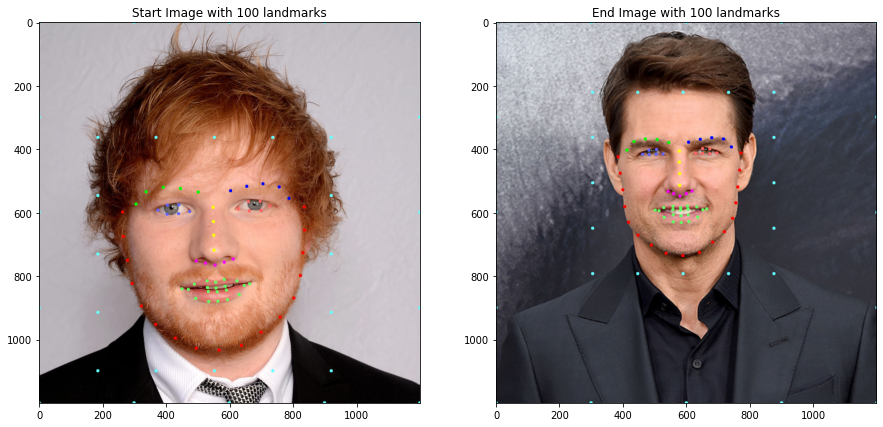

In [10]:
# create a face detector object
faceDetector = dlib.get_frontal_face_detector()
# create a face landmark predictor object
predictor_path = "./shape_predictor_68_face_landmarks.dat"
landmarkDetector = dlib.shape_predictor(predictor_path)

# get the list contains the x,y coordinate of the landmarks on both images
landmarksStart = getLandmarksListFromImg(startImg, faceDetector, landmarkDetector)
landmarksEnd = getLandmarksListFromImg(endImg, faceDetector, landmarkDetector)
print("number of points on start images: ", len(landmarksStart))
print("number of points on end images: ", len(landmarksEnd))

# get the images with landmarks and display them
startImg_landmarks = drawLandmarksOnImage(startImg, landmarksStart)
endImg_landmarks = drawLandmarksOnImage(endImg, landmarksEnd)

# plot images
plot2Images(startImg_landmarks, endImg_landmarks, "Start Image with {n} landmarks".format(n=len(landmarksStart)), "End Image with {n} landmarks".format(n=len(landmarksEnd)))

# 3.) Delaunay Triangulation Using scipy

In [11]:
def getDelaunayTriList(landmarksList):
    landmarksList = np.array(landmarksList)
    # use the scipy built-in function to get the Delaunay triangles from the given coordinate list
    delaunayObj = Delaunay(landmarksList)
    # get a list of vertices index of the triangles
    triList = delaunayObj.simplices
    
    return triList

In [12]:
# draw delaunay triangles on image
def drawDelaunayTrianglesOnImage(image, landmarksList, triList):
    img = np.array(image)
    triCoordList = landmarksList[triList]
    for i, tri in enumerate(triCoordList):
        img = cv2.line(img, tri[0], tri[1], (240, 255, 255), 2)    
        img = cv2.line(img, tri[1], tri[2], (240, 255, 255), 2)
        img = cv2.line(img, tri[2], tri[0], (240, 255, 255), 2)
    
    return img

number of triangles of start image 182
number of triangles of end image 182


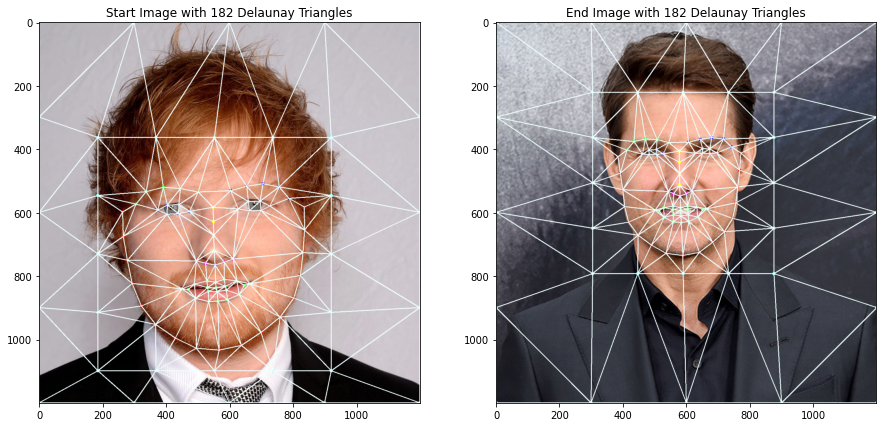

In [13]:
# get a list of the vertices index of the triangles
startTriList = getDelaunayTriList(landmarksStart)
endTriList = getDelaunayTriList(landmarksEnd)

print("number of triangles of start image", len(startTriList))
print("number of triangles of end image", len(endTriList))

# create the triangulation on the image with landmarks
startImg_Tri = drawDelaunayTrianglesOnImage(startImg_landmarks, landmarksStart, startTriList)
endImg_Tri = drawDelaunayTrianglesOnImage(endImg_landmarks, landmarksEnd, endTriList)

# plot the images
plot2Images(startImg_Tri, endImg_Tri, "Start Image with {n} Delaunay Triangles".format(n=len(startTriList)), "End Image with {n} Delaunay Triangles".format(n=len(endTriList)))

# 4.) Linear Interpolation to get the Intermediate Landmarks Coordinates

Create an intermediate landmarks positions by linear interpolation.

In [14]:
def getIntermediateLandmarks(landmarksStart, landmarksEnd, t):
    landmarksInter = []
    # create intermediate shape by linear interpolation using the weight t
    for i in range(len(landmarksStart)):
        x = (1 - t) * landmarksStart[i][0] + t * landmarksEnd[i][0]
        y = (1 - t) * landmarksStart[i][1] + t * landmarksEnd[i][1]
        landmarksInter.append([x, y])
    return landmarksInter

Estimate the affine transformation matrix.

# 5.) Estimate Affine Transformation Matrix

For every point (x,y), we want to transform it to ($x^{'}, y^{'}$) using an affine transformation matrix,
\begin{gather}
    \begin{bmatrix}
    x^{'}\\
    y^{'}\\
    \end{bmatrix}
    =
    \begin{bmatrix}
    a & b & t_x\\
    c & d & t_y
    \end{bmatrix}
    \begin{bmatrix}
    x\\
    y\\
    1
    \end{bmatrix}
\end{gather}

To estimate a, b, c, d, $t_x$ and $t_y$ from the affine transformation matrix using 3 pairs of points ($x_0$, $y_0$)($x_0^{'}$, $y_0^{'}$),  ($x_1$, $y_1$) ($x_1^{'}$, $y_1^{'}$), and  ($x_2$, $y_2$) ($x_2^{'}$, $y_2^{'}$), 
<br>
we can rewrite the points in another form of matrix, such that 
<br>
\begin{gather}
    \begin{bmatrix}
    x_0 & y_0 & 0 & 0 & 1 & 0\\
    0 & 0 & x_0 & y_0 & 0 & 1\\
    x_1 & y_1 & 0 & 0 & 1 & 0\\
    0 & 0 & x_1 & y_1 & 0 & 1\\
    x_2 & y_2 & 0 & 0 & 1 & 0\\
    0 & 0 & x_2 & y_2 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
    a\\
    b\\
    c\\
    d\\
    t_x\\
    t_y
    \end{bmatrix}
    =
    \begin{bmatrix}
    x_0^{'}\\
    y_0^{'}\\
    x_1^{'}\\
    y_1^{'}\\
    x_2^{'}\\
    y_2^{'}
    \end{bmatrix}
\end{gather}
<br>
\begin{gather}
    \begin{bmatrix}
    a\\
    b\\
    c\\
    d\\
    t_x\\
    t_y
    \end{bmatrix}
    =
    \begin{bmatrix}
    x_0 & y_0 & 0 & 0 & 1 & 0\\
    0 & 0 & x_0 & y_0 & 0 & 1\\
    x_1 & y_1 & 0 & 0 & 1 & 0\\
    0 & 0 & x_1 & y_1 & 0 & 1\\
    x_2 & y_2 & 0 & 0 & 1 & 0\\
    0 & 0 & x_2 & y_2 & 0 & 1
    \end{bmatrix}^{ -1}
    \begin{bmatrix}
    x_0^{'}\\
    y_0^{'}\\
    x_1^{'}\\
    y_1^{'}\\
    x_2^{'}\\
    y_2^{'}
    \end{bmatrix}
\end{gather}
<br>
Finally, we get our 2 by 3 affine transformation matrix:
\begin{gather}
    T
    =
    \begin{bmatrix}
    a & b & t_x\\
    c & d & t_y
    \end{bmatrix}
\end{gather}

In [15]:
# return a 2 by 3 affine transformation matrix
def getEstimateAffineTransformMatrix(srcTri, dstTri):
    srcP1 = srcTri[0]
    srcP2 = srcTri[1]
    srcP3 = srcTri[2]
    dstP1 = dstTri[0]
    dstP2 = dstTri[1]
    dstP3 = dstTri[2]
    
    srcMat = np.array([[srcP1[0], srcP1[1], 0, 0, 1, 0],
                       [0, 0, srcP1[0], srcP1[1], 0, 1],
                       [srcP2[0], srcP2[1], 0, 0, 1, 0],
                       [0, 0, srcP2[0], srcP2[1], 0, 1],
                       [srcP3[0], srcP3[1], 0, 0, 1, 0],
                       [0, 0, srcP3[0], srcP3[1], 0, 1]] , dtype=np.float32)
    
    dstMat = np.array([dstP1[0],dstP1[1],dstP2[0],dstP2[1],dstP3[0],dstP3[1]] , dtype=np.float32)
    
    transformArr = np.linalg.inv(srcMat) @ dstMat
    
    transformMat = np.array([[transformArr[0], transformArr[1], transformArr[4]],
                             [transformArr[2], transformArr[3], transformArr[5]]] , dtype=np.float32)
    
    return transformMat

# 6.) Image Warping Using Backward Mapping and Bilinear Interpolation

The following function will take in an input image and apply the affine transformation matrix to create a warped image with size (outH, outW, 3).

In [16]:
def getWarpImgBackwardMapping(img, invT, outW, outH):
    
    imgH, imgW = img.shape[0], img.shape[1]
    
    # create an output image with size (outH, outW, 3)
    outImg = np.zeros((outH, outW, 3))
    
    # create a 3 by (outW*outH) matrix with all the homogeneous coordinates of the output image 
    outYCoord, outXCoord = np.indices((outH, outW))
    outXCoord = (outXCoord.flatten()).astype(np.float32)
    outYCoord = (outYCoord.flatten()).astype(np.float32)
    outImgHomoCoordsMat = np.vstack((outXCoord, outYCoord, np.ones(outW * outH)))
    
    # backward map all the points of the output image,
    # to the corresponding point of the input image using the transformation matrix.
    # imgCoordsMat is a 2 by (outW*outH) non-homogeneous matrix
    # each point from the imgCoordsMat will have a float value due to backward mapping
    imgCoordsMat = invT @ outImgHomoCoordsMat
    
    # get the x and y coordinates from input image coordinates matrix
    imgXCoord = imgCoordsMat[0]
    imgYCoord = imgCoordsMat[1]
    
    # !!!! we need to change some transformed x,y coordinate since they may land outside the input image !!!! #
    # the points that outside the input image will be something like a reflection of the inside
    imgXCoord[imgXCoord < 0] = (imgXCoord[imgXCoord < 0] % (imgW-1)) * -1 
    imgYCoord[imgYCoord < 0] = (imgYCoord[imgYCoord < 0] % (imgH-1)) * -1
    imgXCoord[imgXCoord > imgW-1] = ((imgW-1) - (imgXCoord[imgXCoord > imgW-1] - (imgW-1))) % (imgW-1)
    imgYCoord[imgYCoord > imgH-1] = ((imgH-1) - (imgYCoord[imgYCoord > imgH-1] - (imgH-1))) % (imgH-1)
    
    # bilinear interpolation 
    
    # top-left coordinates
    tlX = np.floor(imgXCoord).astype(int)
    tlY = np.floor(imgYCoord).astype(int)
    
    # top_right coordinates
    trX = np.ceil(imgXCoord).astype(int)
    trY = np.floor(imgYCoord).astype(int)
    
    # bottom-left coordinates
    blX = np.floor(imgXCoord).astype(int)
    blY = np.ceil(imgYCoord).astype(int)
    
    # bottom-right coordinates
    brX = np.ceil(imgXCoord).astype(int)
    brY = np.ceil(imgYCoord).astype(int)
    
    # delta x and delta y from top-left corner
    dx = (imgXCoord - tlX.astype(float)).reshape(-1,1)
    dy = (imgYCoord - tlY.astype(float)).reshape(-1,1)
    
    outYCoord = outYCoord.astype(int)
    outXCoord = outXCoord.astype(int)
    
    # for every x and y from the output image, we have applied inverse transform to the input image,
    # however the x,y coordinate of the input image may not be an interger,
    # in order to access the color from the input image for every corresponding pixel of the output image,
    # we get the color of the neighbouring pixels of the input image,
    # and use bilinear interpolation to estimate the color of the corresponding pixel of the output image.
    outImg[outYCoord, outXCoord] = dx * dy * img[brY, brX] + dx * (1-dy) * img[trY, trX] \
                             + (1-dx) * dy * img[blY, blX] + (1-dx) * (1-dy) * img[tlY, tlX]
    
    return outImg

In [17]:
def getWarpImg(startOrEndImg, triStartOrEnd, triInter, outW, outH):
    
    srcTri = triInter
    dstTri = triStartOrEnd
    
    # estimate the affine transform and get the inverse matrix of the affine transform
    invT = getEstimateAffineTransformMatrix(srcTri, dstTri)
    
    # warp the start or end image by backward mapping and bilinear interpolation
    # return an warped image with size (outH, outW, 3)
    warpImg = getWarpImgBackwardMapping(startOrEndImg, invT, outW, outH)

    return warpImg

The following function will warp the bounding rectangle of the corresponding triangle from the start and end image towards the bounding rectangle of the corresponding triangle of the intermediate image. 

In [18]:
def warpCorrespondingTriangles(startImg, endImg, interImg, triStart, triEnd, triInter, t):
    
    # get the bounding box of the corresponding triangles
    xStart, yStart, wStart, hStart = cv2.boundingRect(np.float32([triStart]))
    xEnd, yEnd, wEnd, hEnd = cv2.boundingRect(np.float32([triEnd]))
    xInter, yInter, wInter, hInter = cv2.boundingRect(np.float32([triInter]))
    
    # create a cropped bounding rectangle for the triangles by shifting the coordinates, 
    # such that the top-left of the bounding box is (0,0) and the bottom-right is (w,h), 
    # and the cropped triangle coordinates is with respect to these cropped bounding box
    triStartCropped = []
    triEndCropped = []
    triInterCropped = []
    
    # shifting the triangle coordinates from startImg world coordinate to its bounding box world coordinate
    for i in range(3):
        triStartCropped.append([(triStart[i][0] - xStart), (triStart[i][1] - yStart)])
        triEndCropped.append([(triEnd[i][0] - xEnd), (triEnd[i][1] - yEnd)])
        triInterCropped.append([(triInter[i][0] - xInter), (triInter[i][1] - yInter)])
        
    # crop a rectangle from the start and end image that bound the corresponding triangle
    startImgCropped = startImg[ yStart : (yStart + hStart), xStart : (xStart + wStart)]
    endImgCropped = endImg[yEnd : (yEnd + hEnd), xEnd : (xEnd + wEnd)]
    
    # warp the cropped start and end image towards the corresponding bounding box of the intermediate image
    warpImgFromStartCropped = getWarpImg(startImgCropped, triStartCropped, triInterCropped, wInter, hInter)
    warpImgFromEndCropped = getWarpImg(endImgCropped, triEndCropped, triInterCropped, wInter, hInter)
    
    # cross dissolve the color of the two warped images
    interImgCropped = ((1.0 - t) * warpImgFromStartCropped) + (t * warpImgFromEndCropped)
    
    # create a mask to black out all pixels outside the triangle
    # the mask will have the same size as the triInter's bounding box 
    # and the triangle region will have the value of 1, otherwise 0
    mask = np.zeros((hInter, wInter, 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(triInterCropped), (1.0, 1.0, 1.0))

    # create a triangle hole on the intermediate image
    # the color of the triangle region will have the value (0,0,0) 
    interImg[yInter : (yInter + hInter), xInter : (xInter + wInter)] *= (1 - mask)
    
    # apply the mask to the cropped intermediate image,
    # so that only the pixels inside the triangle region will have color
    interImgCroppedMasked = interImgCropped * mask
    
    # stick the triangle to the hole
    interImg[yInter : (yInter + hInter), xInter : (xInter + wInter)] += interImgCroppedMasked


In [19]:
def createIntermediateMorphImg(startImg, endImg, landmarksStart, landmarksEnd, t):
    
    # for each weight t, get the intermediate landmarks coordinate
    landmarksInter = getIntermediateLandmarks(landmarksStart, landmarksEnd, t)
        
    # create an empty array for the intermediate image 
    interImg = np.zeros(startImg.shape, dtype=startImg.dtype)
    
    # get a list of triangle vertices by delaunay triangulation using the intermediate landmarks
    interTriList = getDelaunayTriList(landmarksInter)

    # for each triangle in the intermediate triangle list,
    # warp each pair of corresponding triangle from the start and end image
    # towards the corresponding triangle of the intermediate image
    # and apply cross-dissolving for the color
    for i, tri in enumerate(interTriList):
        vertex1 = tri[0]
        vertex2 = tri[1]
        vertex3 = tri[2]

        # create 3 corresponding triangles
        triStart = [landmarksStart[vertex1], landmarksStart[vertex2], landmarksStart[vertex3]]
        triEnd = [landmarksEnd[vertex1], landmarksEnd[vertex2], landmarksEnd[vertex3]]
        triInter = [landmarksInter[vertex1], landmarksInter[vertex2], landmarksInter[vertex3]]
        
        # warp triStart and triEnd towards triInter
        warpCorrespondingTriangles(startImg, endImg, interImg, triStart, triEnd, triInter, t)
        
    return interImg

Test the above backward mapping algorithm by just create one intermediate image.

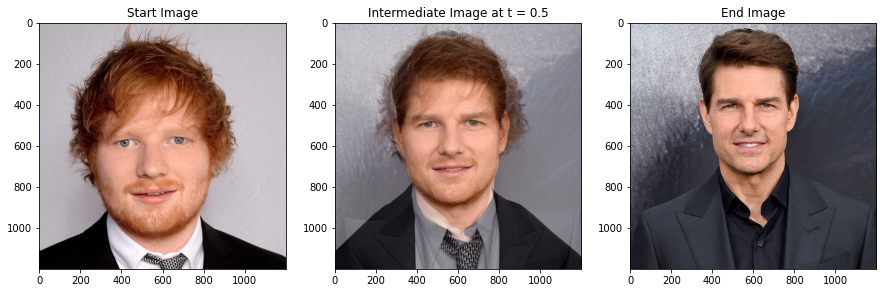

In [20]:
# weight t with value from 0 to 1 
t = 0.5

# create an intermediate image
interImg = createIntermediateMorphImg(np.float32(startImg), np.float32(endImg), landmarksStart, landmarksEnd, t)

plot3Images(startImg, interImg.astype(np.uint8), endImg, "Start Image", "Intermediate Image at t = {w}".format(w=t), "End Image")

# 7.) Create All Intermediate Images and Store to Images List

In [21]:
def getFaceMorphingImagesList(startImg, endImg, landmarksStart, landmarksEnd, duration, fps):

    startImg = np.float32(startImg)
    endImg = np.float32(endImg)
    noOfFrames = duration * fps
    imagesList = []
    
    imagesList.append(startImg)
    for i in range(1, noOfFrames):
        t = i / noOfFrames
        # for each weight t, create an intermediate morph image
        interImg = createIntermediateMorphImg(startImg, endImg, landmarksStart, landmarksEnd, t)
        # append the intermediate morph image into the images list
        imagesList.append(np.array(interImg, dtype=np.uint8))
    imagesList.append(endImg)
    
    print("created ", len(imagesList), " intermdeiate frames.")
        
    return imagesList

In [22]:
duration = 2
fps = 60
imagesList = getFaceMorphingImagesList(startImg, endImg, landmarksStart, landmarksEnd, duration, fps)

created  121  intermdeiate frames.


Check the intermediate image from the image list before creating video.

In [23]:
# plot the start image, k-th intermediate image, and end image from the image list
def plotFromImageList(imagesList, imgIdx):
    if imgIdx >= len(imagesList):
        print("Image index should between 0 to ", (len(imagesList)-1))
        return
    
    fig = plt.figure(figsize=(15, 15))
    ax1 = plt.subplot(1, 3, 1)
    ax1.title.set_text("Start Image")
    plt.imshow(imagesList[0].astype(np.uint8))
    ax2 = plt.subplot(1, 3, 2)
    ax2.title.set_text("Intermediate Morph Image")
    plt.imshow(imagesList[imgIdx].astype(np.uint8))
    ax3 = plt.subplot(1, 3, 3)
    ax3.title.set_text("End Image")
    plt.imshow(imagesList[len(imagesList)-1].astype(np.uint8))

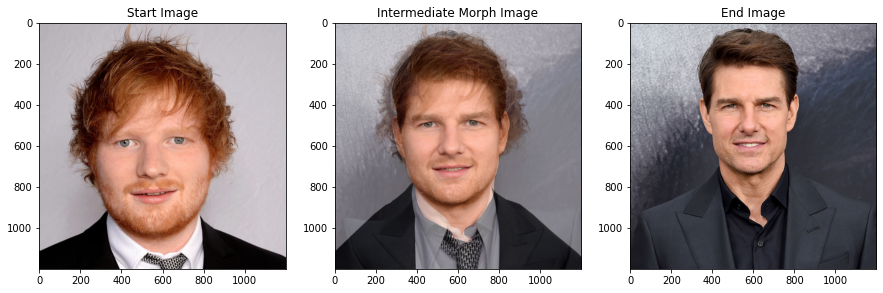

In [24]:
# plot the start and end image, as well as the k-th image from the image list
k = 60
plotFromImageList(imagesList, k)

# 8.) Save All Intermediate Images and Create Face Morphing Video

In [25]:
def saveImagesListToFolder(imagesList, folderName):
    for i, img in enumerate(imagesList):
        imgBGR = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgName = "/%03d.jpg" % i
        fileName = folderName + imgName
        cv2.imwrite(fileName, imgBGR)
    print("Saved ", len(imagesList), " images to folder ", folderName, "!")


In [26]:
def createVideoFromFolder(folderName, outfileName, fps):
    videoCapture = cv2.VideoCapture(folderName + '/%03d.jpg')
    # obtain frame size information using get() method
    frameWidth = int(videoCapture.get(3))
    frameHeight = int(videoCapture.get(4))
    frameSize = (frameWidth,frameHeight)
    
    # initialize video writer object
    videoWriter = cv2.VideoWriter(outfileName, cv2.VideoWriter_fourcc('M','J','P','G'), fps, frameSize)

    frameCount = 0
    while(videoCapture.isOpened()):
        # the read() method will returns a tuple(retrieve = True/False, frame)
        retrieve, frame = videoCapture.read()
        if retrieve == True:
            # Write the frame to the output video file
            videoWriter.write(frame)
            frameCount += 1
        else:
            print("Stream disconnected, ", frameCount, " frames retrieved.")
            break
    videoCapture.release()
    videoWriter.release()
    print("Video released!")


In [27]:
# save images from image list to a folder, then create video using the images from the folder
folderName = "./Intermediate_Images"
outfileName = "./imageMorph.avi"
saveImagesListToFolder(imagesList, folderName)
createVideoFromFolder(folderName, outfileName, fps)

Saved  121  images to folder  ./Intermediate_Images !
Stream disconnected,  121  frames retrieved.
Video released!
